<h1>Final Project
</h1>

<div class="alert alert-block alert-info">
    
# Index<a class="anchor"><a id='menu'></a><br>
* [<font color='#E8800A'>Introduction</font>](#first-bullet) <br>
- [<font color='#E8800A'>Exploratory Analysis</font>](#second-bullet)<br>
- [<font color='#E8800A'>Preprocessing</font>](#third-bullet)<br>
- [<font color='#E8800A'>Modeling</font>](#fourth-bullet)<br>
- [<font color='#E8800A'>Conclusion</font>](#fifth-bullet)<br>
    
</div>

# <font color='#E8800A'>Introduction</font> <a class="anchor" id="first-bullet"></a>
  [Back to TOC](#menu)


**Context:**

 

In January 1st 2020, an epidemy was originated in Albuquerque, in New Mexico state, and spread on the following days to Santa Fe and Taos. It is estimated that the epidemy has already affected more than 1000 people at the end of February, with a mortality rate of more than 50%. It seems there are some groups of people more prone to survive than others and determining which people are more or less proned to survive would be a great help in order to take the necessary precautions accordingly.

 

**Objective:**

 

The aim of this project is to build a **predictive model** that answers the following question: **“Which are the people more likely to survive to the boolean pandemic?”**. This is a classification problem, so the objective is to build a model capable of determining if a person will or will not survive to a pandemic. We will used as **evaluation metric** the **accuracy** (defined by the professors), so our objective will be to build the best model possible, capable of maximizing the number of well classified individuals.

 

**Provided Data:**

 

Different variables were provided, in order to build our predictive model. The variables and respective descriptions are presented below:
- **Patient_ID:** The unique identifier of the patient.
- **Family_Case_ID:** The family identification.
- **Severity:** The severity of the disease, where 1 is the lowest and 3 the highest severity.
- **Name:** The name of the patient.
- **Birthday_year:** The year of birthday of the patient.
- **Parents_Siblings_Infected:** The number of parents and/or siblings infected.
- **Partner_Children_Infected:** The number of partner and/or children infected.
- **Medical_Expenses_Family:** The medical expenses associated to try to contain the epidemy on the family.
- **Medical_Tent:** The medical tent where the patient is / was lodged.
- **City:** The original city of the patient.
- **Deceased:** Flag if the patient deceased or not with the virus (0 = No, 1 = Yes). This will be used as the target variable.

 

It is also important to notice that the train and test data were already separated in advance so we did not have to go through that step.

 

**Process:**

 

We started by doing an **exploratory analysis** to better know the provided data. After that, we did the **preprocessing** of the data, including **duplicates check, incoherences check, outliers treatment and missing values treatment**. Then, we did some **feature engineering** and we ended up applying different **feature selection** techniques, in order to pick the most relevant variables for our model. Finally, different models were tried and results were compared, ending up with the best model through which the best results were obtained.


In [1]:
# Imports
import pandas as pd
import numpy as np
from numpy import mean, std
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import datetime
import math
from pandas import read_csv
import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer

from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import RidgeClassifier, RidgeCV
from sklearn.svm import SVC
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import auc, roc_curve

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.ensemble import StackingClassifier

Using TensorFlow backend.


In [2]:
# Import train and test data sets
dftrain = pd.read_csv(r'./train.csv', sep=',')
dftest = pd.read_csv(r'./test.csv', sep=',')

# Create a dfOriginal in case we want to check original data after data transformations
dforiginal = dftrain.copy(deep=True)

# <font color='#E8800A'>Exploratory Analysis</font> <a class="anchor" id="second-bullet"></a>
  [Back to Menu](#menu)

<h3> Initial Analysis

In [3]:
# Check number of variables and observations in train and test set
print('The train set has {} individuals and {} variables'.format(dftrain.shape[0],dftrain.shape[1]))
print('The test set has {} individuals and {} variables'.format(dftest.shape[0],dftest.shape[1]))
trainPerc = int(dftrain.shape[0]/(dftrain.shape[0]+dftest.shape[0])*100)
testPerc = int(dftest.shape[0]/(dftrain.shape[0]+dftest.shape[0])*100)
print('The train set has {}% and the test has {}% of the total of individuals'.format(trainPerc,testPerc)) 

The train set has 900 individuals and 11 variables
The test set has 400 individuals and 10 variables
The train set has 69% and the test has 30% of the total of individuals


In [4]:
# Is train set balanced?
dftrain.Deceased.value_counts()

1    553
0    347
Name: Deceased, dtype: int64

The train set is **more or less balanced**. We will consider later on the possibility of applying oversampling or applying stratified methods, even having an unbalancement which is not that significant.

In [5]:
# Check variables names on train set
dftrain.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City', 'Deceased'],
      dtype='object')

In [6]:
# Check variables names on test set
dftest.columns

Index(['Patient_ID', 'Family_Case_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents or siblings infected', 'Wife/Husband or children infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City'],
      dtype='object')

As the **names of the variables are not that easy to mention**, we decided to change them to simpler names. Also, the variables 'Parents or siblings infected' and 'Wife/Husband or children infected' **names did not correspond to their true meaning** so we changed to names corresponding to the true meaning.

In [7]:
# Change variables names
dftrain.columns= ['ID', 'Family_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents_Children_Infected', 'Wife_Husband_Siblings_Infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City', 'Deceased']

dftest.columns= ['ID', 'Family_ID', 'Severity', 'Name', 'Birthday_year',
       'Parents_Children_Infected', 'Wife_Husband_Siblings_Infected',
       'Medical_Expenses_Family', 'Medical_Tent', 'City']

In [8]:
# Get overall information about variables in dftrain
dftrain.describe(include='all')

,ID,Family_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Wife_Husband_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
count,900.000000,900.000000,900.000000,900,723.000000,900.000000,900.000000,900.000000,198,898,900.000000
unique,NaN,NaN,NaN,899,NaN,NaN,NaN,NaN,8,3,NaN
top,NaN,NaN,NaN,Mr. Samuel Darnell,NaN,NaN,NaN,NaN,C,Santa Fe,NaN
freq,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,57,649,NaN
mean,450.500000,14305.827778,2.313333,NaN,1990.266943,0.380000,0.521111,895.743333,NaN,NaN,0.614444
std,259.951919,25418.153900,0.834223,NaN,14.523335,0.803247,1.098385,1385.829926,NaN,NaN,0.486997
min,1.000000,345.000000,1.000000,NaN,1940.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,225.750000,8203.000000,2.000000,NaN,1982.000000,0.000000,0.000000,221.000000,NaN,NaN,0.000000
50%,450.500000,13593.500000,3.000000,NaN,1992.000000,0.000000,0.000000,405.000000,NaN,NaN,1.000000
75%,675.250000,18906.500000,3.000000,NaN,1999.500000,0.000000,1.000000,861.250000,NaN,NaN,1.000000


In [9]:
# Check data types
print('Data types in train set:')
print(dftrain.dtypes)
print()
print('Data types in test set:')
print(dftest.dtypes)

Data types in train set:
ID                                  int64
Family_ID                           int64
Severity                            int64
Name                               object
Birthday_year                     float64
Parents_Children_Infected           int64
Wife_Husband_Siblings_Infected      int64
Medical_Expenses_Family             int64
Medical_Tent                       object
City                               object
Deceased                            int64
dtype: object

Data types in test set:
ID                                  int64
Family_ID                           int64
Severity                            int64
Name                               object
Birthday_year                     float64
Parents_Children_Infected           int64
Wife_Husband_Siblings_Infected      int64
Medical_Expenses_Family             int64
Medical_Tent                       object
City                               object
dtype: object


In [10]:
# Check Null values 
print('Null values in train set:')
print(dftrain.isna().sum())
print()
print('Null values in test set:')
print(dftest.isna().sum())

Null values in train set:
ID                                  0
Family_ID                           0
Severity                            0
Name                                0
Birthday_year                     177
Parents_Children_Infected           0
Wife_Husband_Siblings_Infected      0
Medical_Expenses_Family             0
Medical_Tent                      702
City                                2
Deceased                            0
dtype: int64

Null values in test set:
ID                                  0
Family_ID                           0
Severity                            0
Name                                0
Birthday_year                      82
Parents_Children_Infected           0
Wife_Husband_Siblings_Infected      0
Medical_Expenses_Family             0
Medical_Tent                      311
City                                0
dtype: int64


**Null values Conclusions:**
- There are **too many null values in Medical_Tent**. In 900 individuals there are 702 with Null values on this variable. We will probably drop this variable later on.
- Birthday_Year and City also have null values.

<h3> Variables' Visualization

As a way of starting to know the available variables, we decided to plot them. As our objective with this project is to built a **predictive model capable of determining the variable Deceased**, the visualizations were built in such a way of **differentiating between the two categories of this target variable**. 

We built **stacked bar charts 100%** for the **categorical, ordinal and for the discrete variables with few values**. Regarding the **remaining numerical variables**, we built a **Pairplot**, through which we were able to observe the **variables' distribution and the relationship between them.**

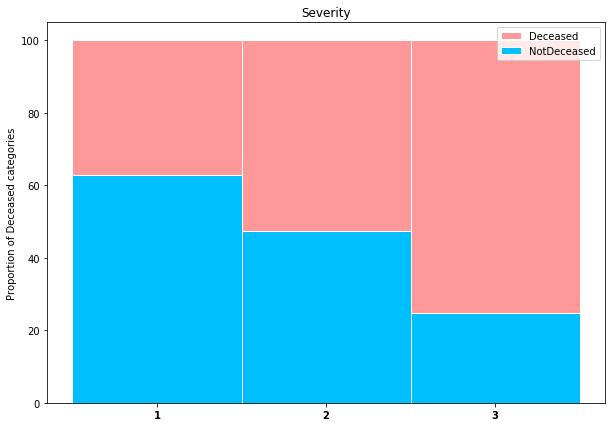

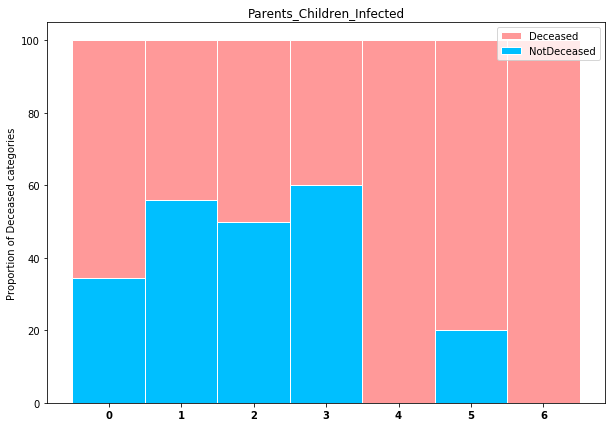

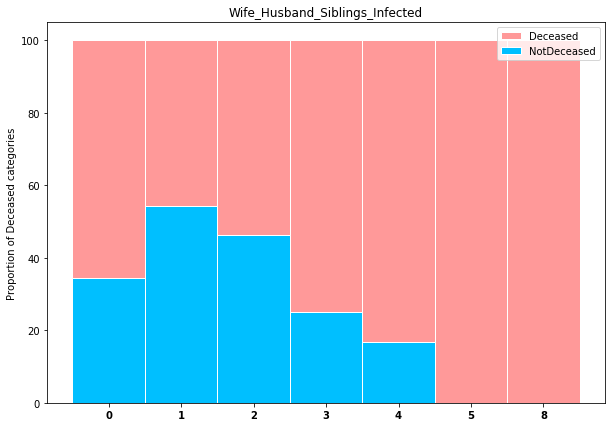

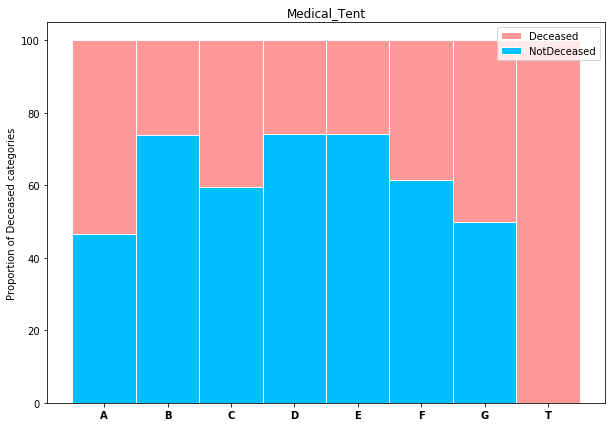

In [11]:
# Plot catergorical, ordinal and discrete variables with few values
# Part of the code taken from: https://medium.com/@priteshbgohil/stacked-bar-chart-in-python-ddc0781f7d5f
plotEval_dftrain = dftrain[['Deceased', 'Severity','Parents_Children_Infected', 'Wife_Husband_Siblings_Infected', 'Medical_Tent', 'City']]

for i in list(plotEval_dftrain.columns[1:5]):
    listCategories = list(plotEval_dftrain[i].value_counts().index)
    Deceased = plotEval_dftrain[i][plotEval_dftrain['Deceased']==1].value_counts().sort_index()
    NotDeceased = plotEval_dftrain[i][plotEval_dftrain['Deceased']==0].value_counts().sort_index()

    for j in listCategories:
        if j not in list(Deceased.index):
            Deceased = Deceased.append(pd.Series([0], index =[j]))
        if j not in list(NotDeceased.index):
            NotDeceased = NotDeceased.append(pd.Series([0], index =[j]))
    Deceased = np.array(Deceased.sort_index().values)
    NotDeceased = np.array(NotDeceased.sort_index().values)
    
    risk =list(plotEval_dftrain[i].value_counts().sort_index().index)

    total = Deceased + NotDeceased
    proportion_Deceased = np.true_divide(Deceased, total) * 100
    proportion_NotDeceased = np.true_divide(NotDeceased, total) * 100
    
    # Add colors
    colors = ['#FF9999', '#00BFFF']
    
    # The position of the bars on the x-axis
    r = range(len(risk))
    barWidth = 1
    
    #plot bars
    plt.figure(figsize=(10,7))
    ax1 = plt.bar(r, proportion_Deceased, bottom=proportion_NotDeceased, color=colors[0], edgecolor='white', width=barWidth, label="Deceased")
    ax2 = plt.bar(r, proportion_NotDeceased, color=colors[1], edgecolor='white', width=barWidth, label='NotDeceased')
    
    plt.legend()
    plt.xticks(r, risk, fontweight='bold')
    plt.ylabel("Proportion of Deceased categories")
    plt.title(i)
    plt.show()
    
    

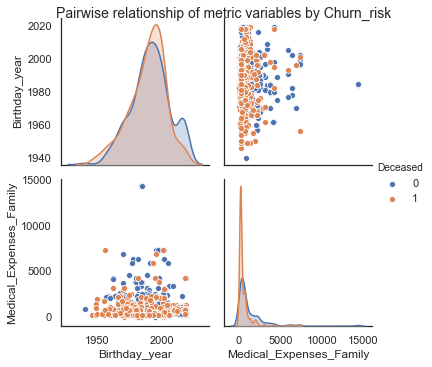

In [12]:
# Check Numerical variables distribution and correlation by category of dependent variable

plotNum_dftrain = dftrain[['Deceased','Birthday_year','Medical_Expenses_Family']]

sns.set()
sns.set_style("white")

sns.pairplot(plotNum_dftrain, vars=['Birthday_year','Medical_Expenses_Family'],hue="Deceased", diag_kind="kde")

plt.subplots_adjust(top=0.95)
plt.suptitle("Pairwise relationship of metric variables by Churn_risk", fontsize=14)
plt.show()

**Conclusions Visualizations:**
- **Severity** is a good variable in terms of differentiating the target variable classes. In fact, the distribution of individuals through the target classes accross different severity levels is different.
- As the other variables presented on the stacked bar charts have many classes/ values, it is difficult to determine if they are good differentiators of the target variable. However, there seems to exist difference of individuals distribution across the target classes on the different values of the variables.
- **Bithday_year** seems to have a near normal distribution.
- **Medical_Expenses_Family** has a skewed distribution so it might be a good idea to apply a logarithmic function over this variable to turn it nearer to a normal distribution.


# <font color='#E8800A'>Preprocessing</font> <a class="anchor" id="third-bullet"></a>
  [Back to TOC](#menu)

<h3> Duplicates

In [13]:
# Check if there are duplicated rows
duplicateRowsDF = dftrain[dftrain.duplicated()]
print('There are {} duplicates in train set'.format(len(duplicateRowsDF)))                           
duplicateRowsDF = dftest[dftest.duplicated()]
print('There are {} duplicates in test set'.format(len(duplicateRowsDF)))  

There are 0 duplicates in train set
There are 0 duplicates in test set


<h3> Incoherences

**Severity:** Check if there are other values besides the ones indicated on the metadata.

**Birthday_year:**
- Check if there values higher than 2020.
- Check if there are too low values that would not make sense.

**Parents_Children_Infected/ Wife_Husband_Siblings_Infected:**
- Check if there are negative values.
- Check if there are values too high that would not make any sense.

**Medical_Expenses_Family:** Check if there are negative values.

**City:** Check if there are only the 3 city values described on the problem context.

**Deceased:** Check if there are only 0 and 1 values.

**Family_Members_Infected and Medical_Expenses_Family:** Check if there are individuals with Family Members infected and with zero medical expenses.

In [14]:
# Get description of all variables
dftrain.describe(include='all')

,ID,Family_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Wife_Husband_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased
count,900.000000,900.000000,900.000000,900,723.000000,900.000000,900.000000,900.000000,198,898,900.000000
unique,NaN,NaN,NaN,899,NaN,NaN,NaN,NaN,8,3,NaN
top,NaN,NaN,NaN,Mr. Samuel Darnell,NaN,NaN,NaN,NaN,C,Santa Fe,NaN
freq,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,57,649,NaN
mean,450.500000,14305.827778,2.313333,NaN,1990.266943,0.380000,0.521111,895.743333,NaN,NaN,0.614444
std,259.951919,25418.153900,0.834223,NaN,14.523335,0.803247,1.098385,1385.829926,NaN,NaN,0.486997
min,1.000000,345.000000,1.000000,NaN,1940.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,225.750000,8203.000000,2.000000,NaN,1982.000000,0.000000,0.000000,221.000000,NaN,NaN,0.000000
50%,450.500000,13593.500000,3.000000,NaN,1992.000000,0.000000,0.000000,405.000000,NaN,NaN,1.000000
75%,675.250000,18906.500000,3.000000,NaN,1999.500000,0.000000,1.000000,861.250000,NaN,NaN,1.000000


**Conclusions Table above:**
- **Birthday_year:** the maximum value is 2019 (which makes sense) and the minimum value is 1940 (it represents someone with 80 years old).
- **Parents_Children_Infected/ Wife_Husband_Siblings_Infected:** there are no negative values and the maximum values are 6 and 8 respectivelly, so there are no weird values on these variables.
- **Medical_Expenses_Family:** there are no negative values on this variable.

In [15]:
# Severity
dftrain.Severity.value_counts() # There are no weird values on severity

3    498
1    216
2    186
Name: Severity, dtype: int64

In [16]:
# City
dftrain.City.value_counts() # There are only 3 values which makes sense, as it is according to the problem context

Santa Fe       649
Albuquerque    169
Taos            80
Name: City, dtype: int64

In [17]:
# Family_Members_Infected and Medical_Expenses_Family
dftrain[(dftrain.Parents_Children_Infected!=0)&(dftrain.Wife_Husband_Siblings_Infected!=0) & (dftrain.Medical_Expenses_Family==0)] 
# No individuals with this incoherence

,ID,Family_ID,Severity,Name,Birthday_year,Parents_Children_Infected,Wife_Husband_Siblings_Infected,Medical_Expenses_Family,Medical_Tent,City,Deceased


<h3> Outliers

**Numerical Variables**

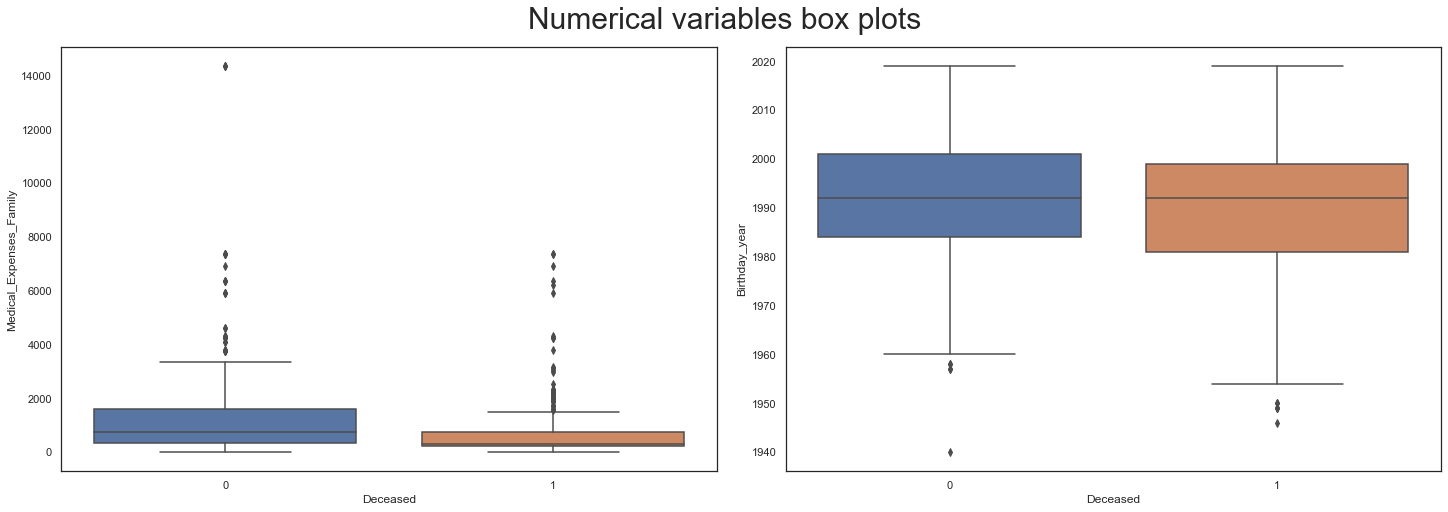

In [18]:
# Box plots for each of the numerical variables to check if there are outliers:

sns.set()
sns.set_style("white")

plot_features = ['Medical_Expenses_Family','Birthday_year']

fig, axes = plt.subplots(1, len(plot_features), figsize=(20,7), constrained_layout=True)
    
for ax, f in zip(axes.flatten(), plot_features):
    sns.boxplot(y=f, data=dftrain, ax=ax, x='Deceased')

plt.suptitle("Numerical variables box plots", fontsize=30)
plt.show()

**Conclusions Box Plots:** There seem to exist outliers in both variables. The outliers in Medical_Expenses_Family are high values and the outliers in Birthday_year are low. Let's check if it makes sense to drop them or not.

In [19]:
# Check outliers of Medical_Expenses_Family
dftrain.Medical_Expenses_Family.value_counts().sort_index().tail(20)

2980     2
3049     2
3105     4
3172     3
3360     4
3742     2
3766     2
3798     3
4103     2
4243     4
4297     3
4616     2
5917     3
5922     1
6210     1
6371     4
6931     2
7347     2
7364     4
14345    3
Name: Medical_Expenses_Family, dtype: int64

The **3 last individuals with Medical_Expenses_Family value of 14345** distinguish a lot from the previous values. Despite being possible for a family to spend 14345 in medical assistance, these values are so different from the others, that would bias the training of the model. Therefore, we decided to **drop them, considering them as outliers.**

In [20]:
# Remove outliers in Medical_Expenses_Family
dftrain = dftrain[dftrain['Medical_Expenses_Family']<=8000]

In [21]:
# Check outliers of Birthday_year
dftrain.Birthday_year.value_counts().sort_index().head(20)

1940.0    1
1946.0    1
1949.0    3
1950.0    2
1954.0    1
1955.0    3
1956.0    2
1957.0    2
1958.0    5
1959.0    3
1960.0    4
1961.0    2
1962.0    5
1963.0    2
1964.0    5
1965.0    2
1966.0    8
1967.0    1
1968.0    6
1969.0    7
Name: Birthday_year, dtype: int64

There is only one value that distinguishes from the others by being **lower (1940).** However, as it **does not differentiate that much, we decided to keep it.**

Now that we checked one dimensional outliers, we decided to check 2 dimensional outliers graphically. **If there is evidence of bi-dimensional outliers, we will apply k-means**, which is commonly used for this purpose as it is an algorithm really **sensitive to outliers.**

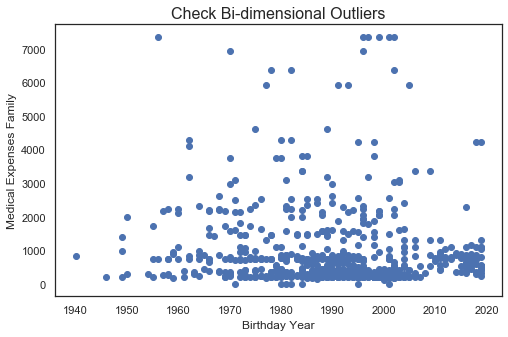

In [22]:
# Plot individually the numerical variables: scatterplots:
plt.figure(figsize=(8,5))
plt.scatter(dftrain['Birthday_year'], dftrain['Medical_Expenses_Family'])
plt.title('Check Bi-dimensional Outliers', fontsize=16)
plt.xlabel('Birthday Year')
plt.ylabel('Medical Expenses Family')


plt.show()

The point on the top left might be an outlier. Therefore, we followed the **K-means approach** mentioned before. It is important to mention that we decided to standardize these two variables in order not to influence the results of the k-means on their scales. It is true that we have already treated the uni-dimensional outliers, so it would make sense to apply the standard scaler as there would not be influence of outliers. However, through the visualizations of the 2 variables, we could observe that not both follow a normal distribution. For this reason, we decided to **apply the min-max scaler**, which is recommended on these cases.

In [23]:
# Standardize the variables to apply the K-means
dfKmeans = dftrain[['ID','Birthday_year','Medical_Expenses_Family']][~dftrain.Birthday_year.isna()]
scaler = MinMaxScaler()
dfKmeans2 = scaler.fit_transform(dfKmeans[['Birthday_year','Medical_Expenses_Family']])
dfKmeans = dfKmeans['ID']
dfKmeans2 = pd.DataFrame(dfKmeans2, columns=['Birthday_year','Medical_Expenses_Family'])
dfKmeans.reset_index(inplace=True, drop=True)
dfKmeans2.reset_index(inplace=True, drop=True)
dfKmeans = pd.concat([dfKmeans,dfKmeans2],axis=1,ignore_index=True)
dfKmeans.columns = ['ID','Birthday_year','Medical_Expenses_Family']

In [24]:
# Build a for loop to access to the composition of different number of clusters
for i in range(4,30):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(dfKmeans[['Birthday_year','Medical_Expenses_Family']])
    print(i)
    for key, value in Counter(kmeans.labels_).items():
        print(str(key)+':'+str(value))

4
1:134
3:324
2:220
0:42
5
4:126
1:301
0:211
2:67
3:15
6
4:103
2:212
1:252
5:71
0:67
3:15
7
4:90
2:205
1:240
5:70
0:41
3:16
6:58
8
2:45
1:187
4:203
7:70
5:39
6:106
3:16
0:54
9
1:35
6:103
7:193
0:185
3:67
4:38
2:24
8:60
5:15
10
1:31
2:103
0:193
8:185
6:66
5:38
9:16
7:59
3:15
4:14
11
1:33
2:108
0:152
8:167
6:65
5:31
10:61
9:15
7:59
3:15
4:14
12
1:40
6:112
7:151
0:166
3:66
11:63
10:16
9:5
5:10
4:26
8:54
2:11
13
1:31
6:108
7:149
0:166
3:66
4:31
11:61
10:15
12:33
9:5
5:10
8:34
2:11
14
1:31
6:85
13:126
0:137
7:98
3:64
11:45
10:15
12:33
9:5
5:10
4:26
8:34
2:11
15
1:31
14:85
13:115
0:105
7:84
3:64
11:38
10:15
12:31
6:70
9:5
5:10
4:22
8:34
2:11
16
11:27
6:88
2:106
15:114
13:84
4:64
12:32
9:16
8:30
1:71
5:8
3:5
14:10
0:34
10:11
7:20
17
11:25
6:88
2:107
15:114
13:77
4:29
16:43
12:32
9:16
8:31
1:71
5:8
3:5
14:10
0:33
10:11
7:20
18
1:27
2:80
14:110
8:125
0:90
15:29
6:44
11:27
9:12
7:29
16:36
12:4
10:37
13:5
3:10
5:12
17:32
4:11
19
1:20
14:65
13:93
0:113
7:90
16:29
3:44
11:32
12:20
18:42
6:55
17:7
1

Looking at the number of individuals per cluster, we realized there was no cluster that distinguished a lot from the others on a small number of individuals. From the 12 cluster number, we noticed there was a cluster with only 5 individuals. However, as the next clusters with few individuals had 10 and 11 individuals (small difference from the smallest one), we decided not to consider the 5 individuals on the smallest cluster as bi-dimensional outliers. Therefore, no further outliers treatment was needed.

<h3> Check and Transform (if necessary) Categorical Variables

Firstly, we considered treating the Medical_Tent variable's categories. Looking at the categories in Medical_Tent, both for train and test sets, as we had concluded before through visualizations, we noticed there was one more tent called T in dftrain that was not in dftest. Also, looking at the train set, we realized that there were too few individuals in tents G and T. For this reason, we considered the possibility of joining these two categories with F category which is the one that has less individuals after those. However, we remembered that this variable has too many null values. For this reason, we decided not to do all the mentioned transformations, as below, on missing values section, we will drop this variable.

Also, regarding the Name variable, firstly, we considered **dropping** it, as it is directly **not useful when building a predictive model.** Besides, regarding GDPR, this variable should not be kept, as individuals should not be identifiable (for individuals differentiation we have the ID through which people cannot be identified). However, we dicided not to drop it directly, as we realized a new variable relative to the sex of the individuals could be obtained though it. In fact, before each name there was an honorific through which we could determine the sex of the individuals. The honorifics Miss, Ms and Mrs correspond to women, and Mr and Mrs to men. We created a function to create the new variable Female through this information (presented below).

In [25]:
# Function to build the Female variable
def change_name_to_gender(df):
    df['Name'] = df['Name'].replace(to_replace='^Miss\s*.*', value='1', regex=True) 
    df['Name'] = df['Name'].replace(to_replace='^Ms\s*.*', value='1', regex=True) 
    df['Name'] = df['Name'].replace(to_replace='^Mr\.\s*.*', value='0', regex=True) 
    df['Name'] = df['Name'].replace(to_replace='^Mrs\s*.*', value='1', regex=True) 
    df['Name'] = df['Name'].replace(to_replace='^Master\s*.*', value='0', regex=True) 
    df = df.rename(columns={"Name": "Female"})
    
    return df
    
# Apply function to train and test sets
dftrain = change_name_to_gender(dftrain)
dftest = change_name_to_gender(dftest)

<h3> Missing values

In [26]:
# Check missing values for all variables
dftrain.isna().sum()

ID                                  0
Family_ID                           0
Severity                            0
Female                              0
Birthday_year                     177
Parents_Children_Infected           0
Wife_Husband_Siblings_Infected      0
Medical_Expenses_Family             0
Medical_Tent                      701
City                                2
Deceased                            0
dtype: int64

There are **177 null values in Birthday_year, 701 null values in Medical_tent and 2 null values in City**. 
- Regarding the variable **Medical_Tent**, as it had so many null values (78% of the rows had null values on this variable), we decided to **drop** it, as predicting these null values would never be really accurate.
- Regarding null values in **City**, we had no idea of which values could be associated with those 2 individuals. Therefore, as they were only 2 null values, we decided to **drop the two corresponding instances.**
- For the null values in **Birthday_year** we decided to treat with the **KNN imputer**. 

In [27]:
# Drop variable Medical_Tent
dftrain = dftrain.drop(columns = ['Medical_Tent'])
dftest = dftest.drop(columns = ['Medical_Tent'])

In [28]:
# Drop 2 rows that have no city
dftrain = dftrain.drop(dftrain[dftrain.City.isna()].index)

Before treating the **null values in Birthday_year**, we had to **encode the variables**, as there was the categorical variable City that would not be possible to use if it was kept as categorical. After encoding this variable, we considered the possibility of **using for the KNN imputer only the most important variables to determine Birthday_year**. To check which variables these could be, we firstly standardized the variables and then checked the **spearman and a pearson correlations** but there was no variable highly correlated in absolute value with Birthday_year. Then, we applied the **Lasso and Ridge regressions** to check the most important set of variables to determine Birthday_year. However, when analysing the results, we realized there were not variables that highlighted a lot on explaining Birthday_year. There were variables with higher values than others on the different techniques, but their scores was not that high. **We ended up using all variables available for the KNN inputer.** The steps described here are presented below.

In [29]:
# Encode the categorical variable City
dftrainNotEncoded = dftrain.copy(deep=True)
dftestNotEncoded = dftest.copy(deep=True)

def enconde_categorical(df):
    dummy = pd.get_dummies(df[['City']])
    df = pd.concat([df,dummy], axis=1)
    df.drop(['City'], axis=1, inplace=True)
    return df

dftrain = enconde_categorical(dftrain)
dftest = enconde_categorical(dftest)

In [30]:
# Drop one binary variable of the encoded variable to avoid multicolinearity
dftrain = dftrain.drop(columns=['City_Santa Fe'])
dftest = dftest.drop(columns=['City_Santa Fe'])

In [31]:
# Standardize data (Scaler):

#dftrain
scaler = StandardScaler()
dfStdVarTrain = dftrain.drop(columns=['Deceased','ID','Family_ID'])

# Scale of necessary vars 
scaled_features = scaler.fit_transform(dfStdVarTrain)
dfStdVarTrain = pd.DataFrame(scaled_features, index=dfStdVarTrain.index, columns=dfStdVarTrain.columns)

# dftest
dfStdVarTest = dftest.drop(columns=['ID', 'Family_ID'])

scaled_features = scaler.transform(dfStdVarTest)
dfStdVarTest = pd.DataFrame(scaled_features, index=dfStdVarTest.index, columns=dfStdVarTest.columns)

**Important Remark about Correlations:** We included the binary variables on the correlation study. It is true that it is wrong to include encoded categorical variables on the correlation study as their values do not have a numerical meaning (they are just indicators of categories). However, if we think in terms of binary variables, it does make sense to include them in the correlation study, as their values have a meaning (existence or non existence/ belonging or not belonging). This is why we included the binary variables on the correlation study. Another important thing to consider is that we excluded the variable Family_ID because of what was said here. This variable is categorical and its values do not have any numerical value. It would not make sense to include it because we would be giving more importance to individuals with higher identifier value than to those with lower.

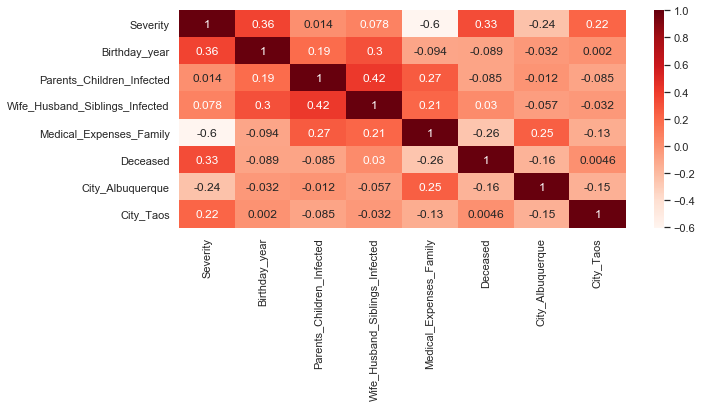

In [32]:
# Pearson Correlations
Pearson_df = dftrain[['Severity', 'Female', 'Birthday_year',
       'Parents_Children_Infected', 'Wife_Husband_Siblings_Infected',
       'Medical_Expenses_Family', 'Deceased', 'City_Albuquerque', 
       'City_Taos']]
cor_pearson = Pearson_df.corr()

# Function to get a heatmap of Pearson Correlations
def cor_heatmap(cor,n,m):
    plt.figure(figsize=(n,m))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds)
    plt.show()

# Plot heatmap
cor_heatmap(cor_pearson,10,4)

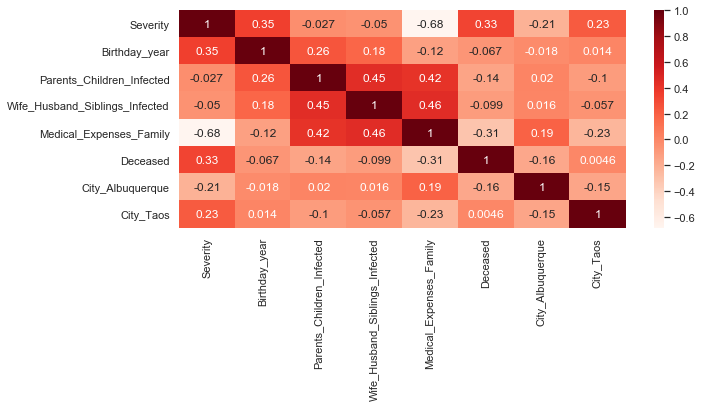

In [33]:
# Spearman Correlation
Spearman_df = dftrain[['Severity', 'Female', 'Birthday_year',
       'Parents_Children_Infected', 'Wife_Husband_Siblings_Infected',
       'Medical_Expenses_Family', 'Deceased', 'City_Albuquerque', 
       'City_Taos']]
cor_spearman = Spearman_df.corr(method ='spearman')

# Plot heatmap
cor_heatmap(cor_spearman,10,4)

In [34]:
# Lasso Regression
data_corr = dftrain.dropna()
target_corr = data_corr[['Birthday_year']]
data_corr = data_corr.drop(columns= ['Deceased','ID','Birthday_year'])
modelSel = LassoCV()
modelSel.fit(X = data_corr, y = target_corr)
print("Best alpha LassoCV: %f" % modelSel.alpha_)

Best alpha LassoCV: 28.959641


In [35]:
# Get coefficients
coef = pd.Series(modelSel.coef_, index = data_corr.columns)
coef.sort_values()

Medical_Expenses_Family          -0.001133
Family_ID                        -0.000014
Severity                          0.000000
Female                            0.000000
Parents_Children_Infected         0.000000
Wife_Husband_Siblings_Infected    0.000000
City_Albuquerque                 -0.000000
City_Taos                        -0.000000
dtype: float64

In [36]:
# Ridge Regression
# Create an instance of ridge regression
ridge = RidgeCV()

# fit into data
ridge.fit(X = data_corr, y = target_corr)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [37]:
coefs = ridge.coef_[0]

In [38]:
# check coefficients
coef = pd.Series(coefs, index = data_corr.columns)
coef.sort_values()

City_Taos                        -2.616562
Family_ID                        -0.000016
Medical_Expenses_Family           0.000708
Parents_Children_Infected         0.802539
City_Albuquerque                  1.991492
Female                            2.954485
Wife_Husband_Siblings_Infected    3.749710
Severity                          7.147859
dtype: float64

**KNN Imputer**

In [39]:
# Train set
# Fit and transform KNN imputer
imputer = KNNImputer(n_neighbors=3)
dftrain_Std_noNan = imputer.fit_transform(dfStdVarTrain)
# Reverse standardization
dftrain_noStd_noNan = pd.DataFrame(scaler.inverse_transform(dftrain_Std_noNan), columns=dfStdVarTrain.columns)
# Transform the Birthday_year values into integers
dftrain_noStd_noNan.Birthday_year = dftrain_noStd_noNan.Birthday_year.astype(int)
# Create dftrain_noNan dataframe with the values already inputed
dftrain = dftrainNotEncoded.copy(deep=True)
dftrain_noStd_noNan.reset_index(drop=True, inplace=True)
dftrain.reset_index(drop=True, inplace=True)
null_indexes = list(dftrain.loc[dftrain.Birthday_year.isna()].index)
dftrain.loc[null_indexes, 'Birthday_year'] = dftrain_noStd_noNan.loc[null_indexes, 'Birthday_year']

# Test set
# Transform test_data with KNN imputer
dftest_Std_noNan = imputer.transform(dfStdVarTest)
# Reverse standardization
dftest_noStd_noNan = pd.DataFrame(scaler.inverse_transform(dftest_Std_noNan), columns=dfStdVarTest.columns)
# Transform the Birthday_year values into integers
dftest_noStd_noNan.Birthday_year = dftest_noStd_noNan.Birthday_year.astype(int)
# Create dftest_noNan dataframe with the values already inputed
dftest = dftestNotEncoded.copy(deep=True)
dftest_noStd_noNan.reset_index(drop=True, inplace=True)
dftest.reset_index(drop=True, inplace=True)
null_indexes = list(dftest.loc[dftest.Birthday_year.isna()].index)
dftest.loc[null_indexes, 'Birthday_year'] = dftest_noStd_noNan.loc[null_indexes, 'Birthday_year']

<h3> Feature Engineering

In [40]:
# Create Nr_Family_Members_Infected 
dftrain['Nr_Family_Members_Infected'] = dftrain['Parents_Children_Infected'] + dftrain['Wife_Husband_Siblings_Infected']
dftest['Nr_Family_Members_Infected'] = dftest['Parents_Children_Infected'] + dftest['Wife_Husband_Siblings_Infected']

In [41]:
# # Fucntion that creates a set of variables grouping patients by Family_ID
# mega_df = dftrain.append(dftest, ignore_index=True)

# def create_variables_family(df):    
#     Family_variables = pd.concat([df.groupby('Family_ID')['Parents_Children_Infected','Wife_Husband_Siblings_Infected'].sum(),df.groupby('Family_ID')['Severity'].count()], axis=1)
#     Family_variables.rename(columns={'Parents_Children_Infected':'Sum_Parents_Children','Wife_Husband_Siblings_Infected': 'Sum_Wife_Husband_Siblings',"Severity": "Registered_Family_Patients"}, inplace=True)
#     Family_variables = Family_variables.merge(df[['Family_ID','Medical_Expenses_Family']].drop_duplicates('Family_ID'), on='Family_ID', how='left')
#     Family_variables['Medical_Expenses_Individual'] = Family_variables['Medical_Expenses_Family']/Family_variables['Registered_Family_Patients']
#     Family_variables['Family_Members_Infected'] = Family_variables['Sum_Parents_Children'] + Family_variables['Sum_Wife_Husband_Siblings']
#     Family_variables['NotRegistered_Members_Infected'] = Family_variables['Family_Members_Infected'] - Family_variables['Registered_Family_Patients']
#     Family_variables.drop(columns=['Medical_Expenses_Family'], inplace = True)
#     return pd.merge(df, Family_variables, on='Family_ID', how='left')

# mega_df = create_variables_family(mega_df)

# dftrain = mega_df.iloc[:895]
# dftest = mega_df[895:]
# dftest.drop(columns=['Deceased'], inplace= True)

We thought about creating new variables based on the Family_ID variable. However, later on we realized including these variables in the model would turn the results much worse. In fact, we suspect this variable has a problem related with its creation. In spite of this, we left the code on the cell above if necessary to check.

In [42]:
# Create variable age through Bithday_year variable
dftrain['Age'] = datetime.datetime.now().year - dftrain['Birthday_year']
dftest['Age'] = datetime.datetime.now().year - dftest['Birthday_year']

In [43]:
# Create variable representing the Medical_Expenses per Infected member of the family
# If Medical_Expenses_Family is zero this means there were no Expenses so the new variable will have value zero
# If Family_Members_Infected is zero then there were no expenses per infected member so the new variable will have value zero
#dftrain['Medical_Expenses_PerMember'] = np.where((dftrain['Medical_Expenses_Family']==0)|(dftrain['Family_Members_Infected']==0), 0, dftrain['Medical_Expenses_Family']/dftrain['Family_Members_Infected'])
#dftest['Medical_Expenses_PerMember'] = np.where((dftest['Medical_Expenses_Family']==0)|(dftest['Family_Members_Infected']==0), 0, dftest['Medical_Expenses_Family']/dftest['Family_Members_Infected'])

In the previous cell we created a variable called Medical_Expenses_PerMember, representing the Medical_Expenses per Infected member of the family. After doing feature selection, we realized this variable was not that good so, we decided to comment it, as it will not be used on the final model.

Let's now **drop the variable Family_ID** as it will not be needed anymore. As it is **categorical**, it **does not make sense to include it in the model because its values have no numerical meaning** (they are just family identifiers). If we included it in the model we would be influencing the results in an incorrect way, as we would be saying individuals with a higher ID would have a higher value than indivíduals with lower ID, which does not make sense.

In [44]:
# Drop Family_ID
dftrain = dftrain.drop(columns=['Family_ID'])
dftest = dftest.drop(columns=['Family_ID'])

<h3> Encode Categorical Variables

In [45]:
# Encode City variable on train and test sets
dftrain = enconde_categorical(dftrain)
dftest = enconde_categorical(dftest)

In [46]:
# Drop City_Taos variable from train and test sets to avoid multicollinearity 
dftrain = dftrain.drop(columns=['City_Taos'])
dftest = dftest.drop(columns=['City_Taos'])

<h2> Division of dftrain into Train and Validation sets

We decided to **split the dftrain data set into train and validation data sets** with 80/20% respectively. We decided so, in order to be able to asses the model performance before submiting to kaggle and getting results for the test set. For this division we used the stratified option. As the dftrain is slightly unbalanced, a **stratified division** was needed in order to split in a stratified way. 


In [47]:
# Split the dftrain into data and target
data = dftrain.drop(columns=['ID','Deceased'])
target = dftrain[['Deceased']]

In [48]:
# Split data into X_train, X_val, y_train and y_val
X_train, X_val, y_train, y_val = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=5)
X_test = dftest.copy(deep=True)
X_test = X_test.drop(columns=['ID'])

<h3>Standartization

In [49]:
# Options:
minmax = False
standardscaler = True 

In [50]:
if minmax:
    #train_data
    min_maxs = MinMaxScaler()
    X_train = min_maxs.fit_transform(X_train)
    #val_data
    X_val = min_maxs.transform(X_val)
    #test_data
    X_test = min_maxs.transform(X_test)
    
if standardscaler:
    #train_data
    sscaler = StandardScaler()
    X_train = sscaler.fit_transform(X_train)
    #val_data
    X_val = sscaler.transform(X_val)
    #val_data
    X_test = sscaler.transform(X_test)

In [51]:
# Update X_train, X_val and X_test with standardized data
X_train = pd.DataFrame(data=X_train, columns=data.columns)
X_val = pd.DataFrame(data=X_val, columns=data.columns)
X_test = pd.DataFrame(data=X_test, columns=data.columns)

<h3> Feature Selection

For feature selection, we decided to have in mind different techniques: **ANova, Decision Tree, Correlations, RidgeClassifier and RFE.** When deciding to apply all these techniques, we had in mind the target variable was categorical. When building the correlation matrices, we included all the available variables. There are no categorical variables besides the binary ones, so it is possible to include all when calculating the correlations (check justification placed before applying the KNN imputer).

**Anova** 

In [52]:
X_anova = X_train.copy(deep=True)
y_anova = y_train.copy(deep=True)
fvalue_selector = SelectKBest(f_classif, k=10)

# Apply the SelectKBest object to the features and target
X_anova_best = fvalue_selector.fit_transform(X_anova, y_anova)
print('Original number of features:', X_anova.shape[1])
print('Reduced number of features:', X_anova_best.shape[1])

Original number of features: 10
Reduced number of features: 10


In [53]:
# Get best variables
mask = fvalue_selector.get_support()
anova_columns_names = []

for boolean, column in zip(mask, data.columns):
    if boolean:
        anova_columns_names.append(column)
anova_columns_names

['Severity',
 'Female',
 'Birthday_year',
 'Parents_Children_Infected',
 'Wife_Husband_Siblings_Infected',
 'Medical_Expenses_Family',
 'Nr_Family_Members_Infected',
 'Age',
 'City_Albuquerque',
 'City_Santa Fe']

In [54]:
# Create a Data Frame with Feature selection results
Selection_Table = pd.DataFrame(columns=['Variables','ANova','Decision Tree','Ridge Classifier','RFE','Count'])
Selection_Table['Variables'] = X_train.columns
Selection_Table['ANova']=np.where(Selection_Table['Variables'].isin(anova_columns_names),1,0)

**Decision Tree**

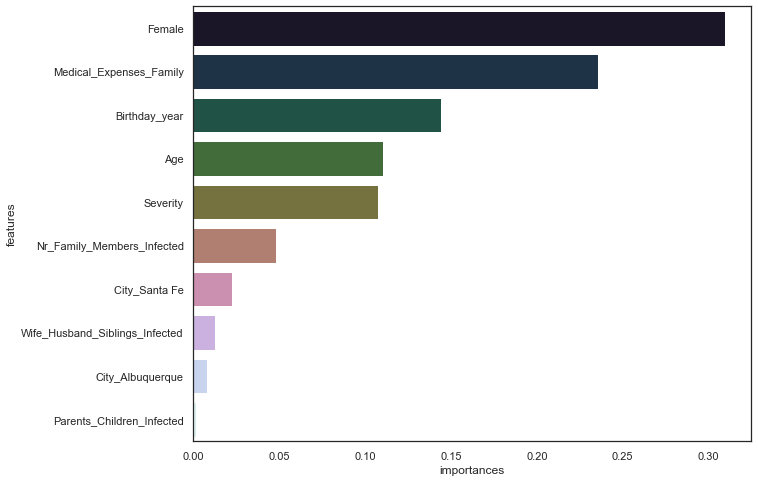

In [55]:
# Apply Decision Tree and get results
decision_tree = DecisionTreeClassifier(random_state = 4)
decision_tree.fit(X_train, y_train)
 
importances = decision_tree.feature_importances_
features = X_train.columns
data_tuples = list(zip(importances, features))
data = pd.DataFrame(data_tuples, columns = ['importances', 'features'])
data = data.sort_values('importances', ascending = False)
plt.figure(figsize=(10,8))
sns.barplot(data['importances'], data['features'], palette = 'cubehelix', orient = 'h')

In [56]:
# select TOP 10 most important variables
data = data.sort_values(by='importances')
data = data.tail(10)
TOPFeaturesDT = list(data.features)
# Update Selection_Table
Selection_Table['Decision Tree']=np.where(Selection_Table['Variables'].isin(TOPFeaturesDT),1,0)

**Correlations**

In [57]:
# Prepare data for correlation study
y_traincoor = y_train.reset_index()
dftrainCorr = pd.concat([X_train,y_traincoor], axis=1,ignore_index=True)
dftrainCorr.columns = list(X_train.columns)+list(y_traincoor.columns)

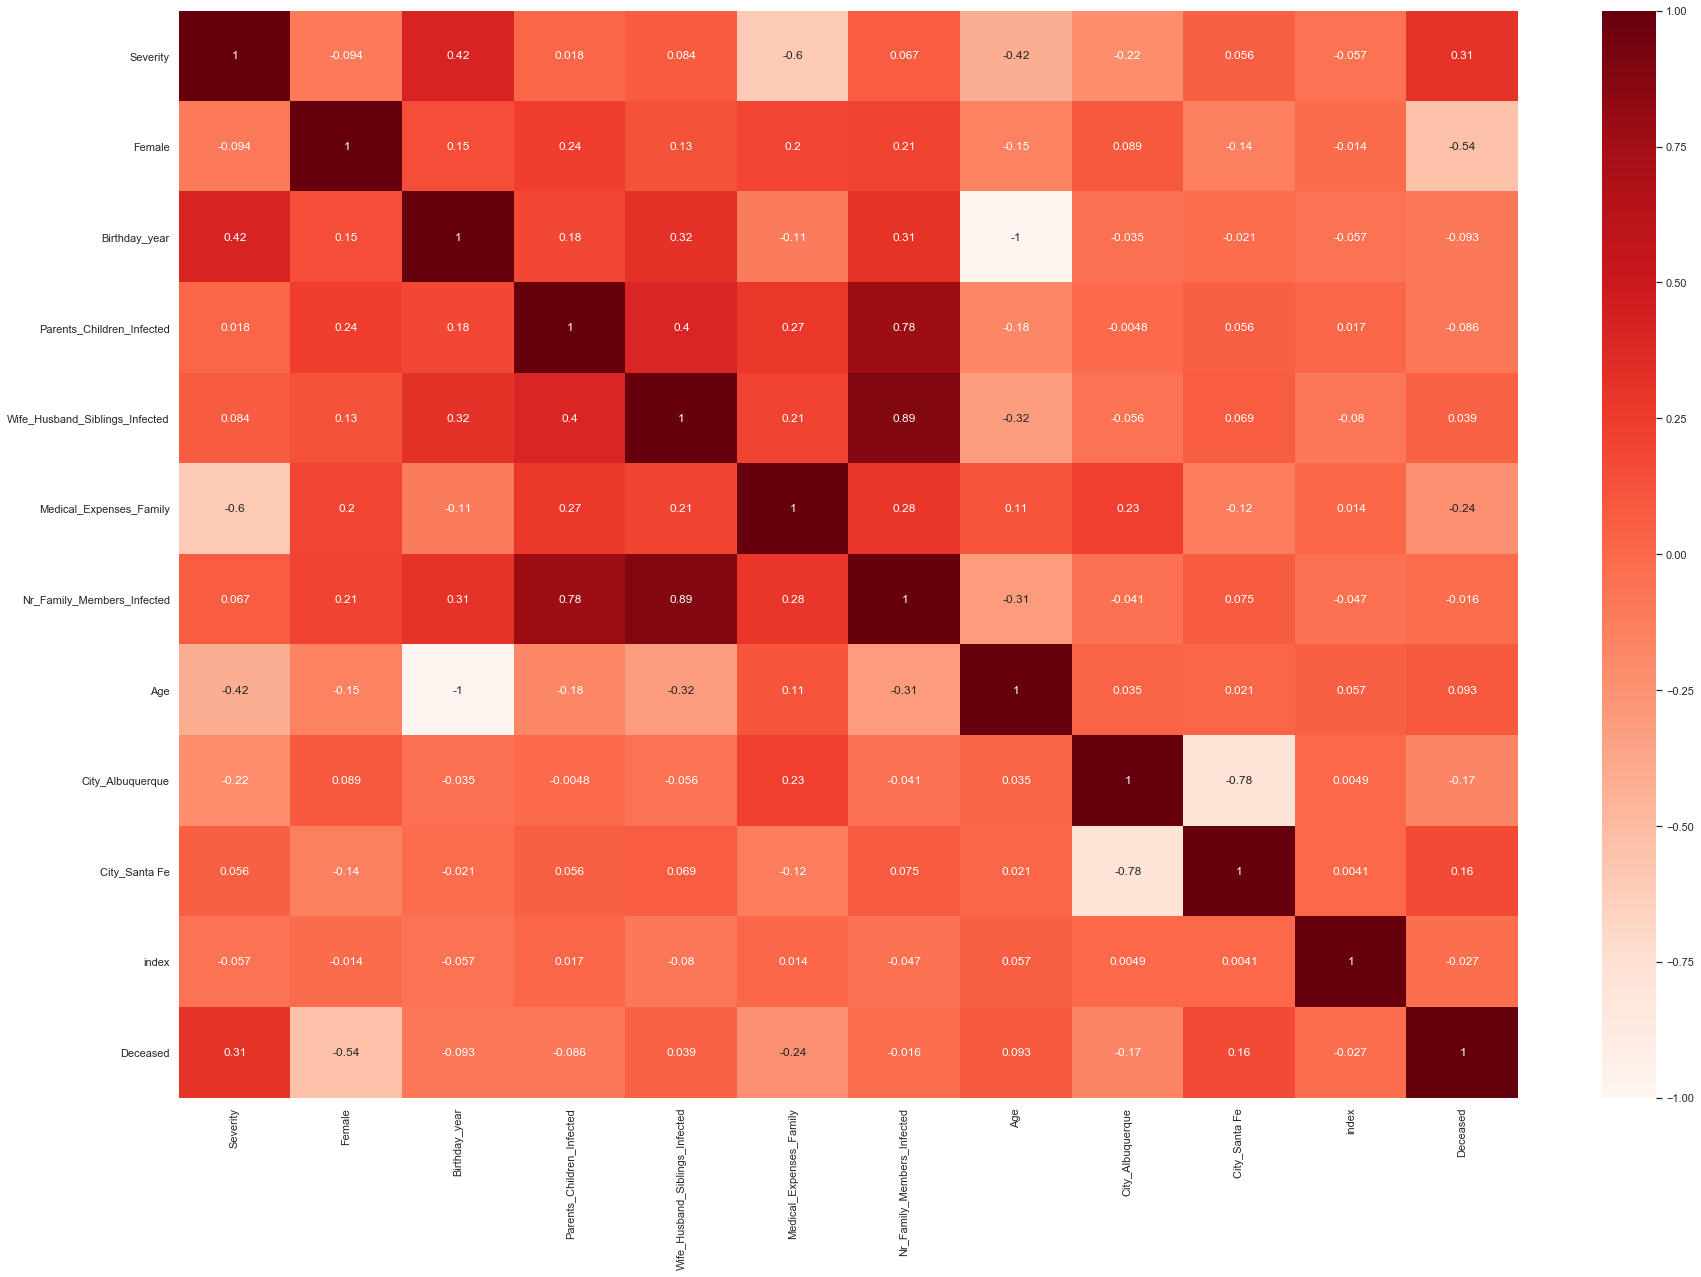

In [58]:
# Get Pearson and Spearman correlations
cor_Pearson = dftrainCorr.corr()
cor_Spearman = dftrainCorr.corr(method ='spearman')

# Get Pearson matrix
cor_heatmap(cor_Pearson,30,20)

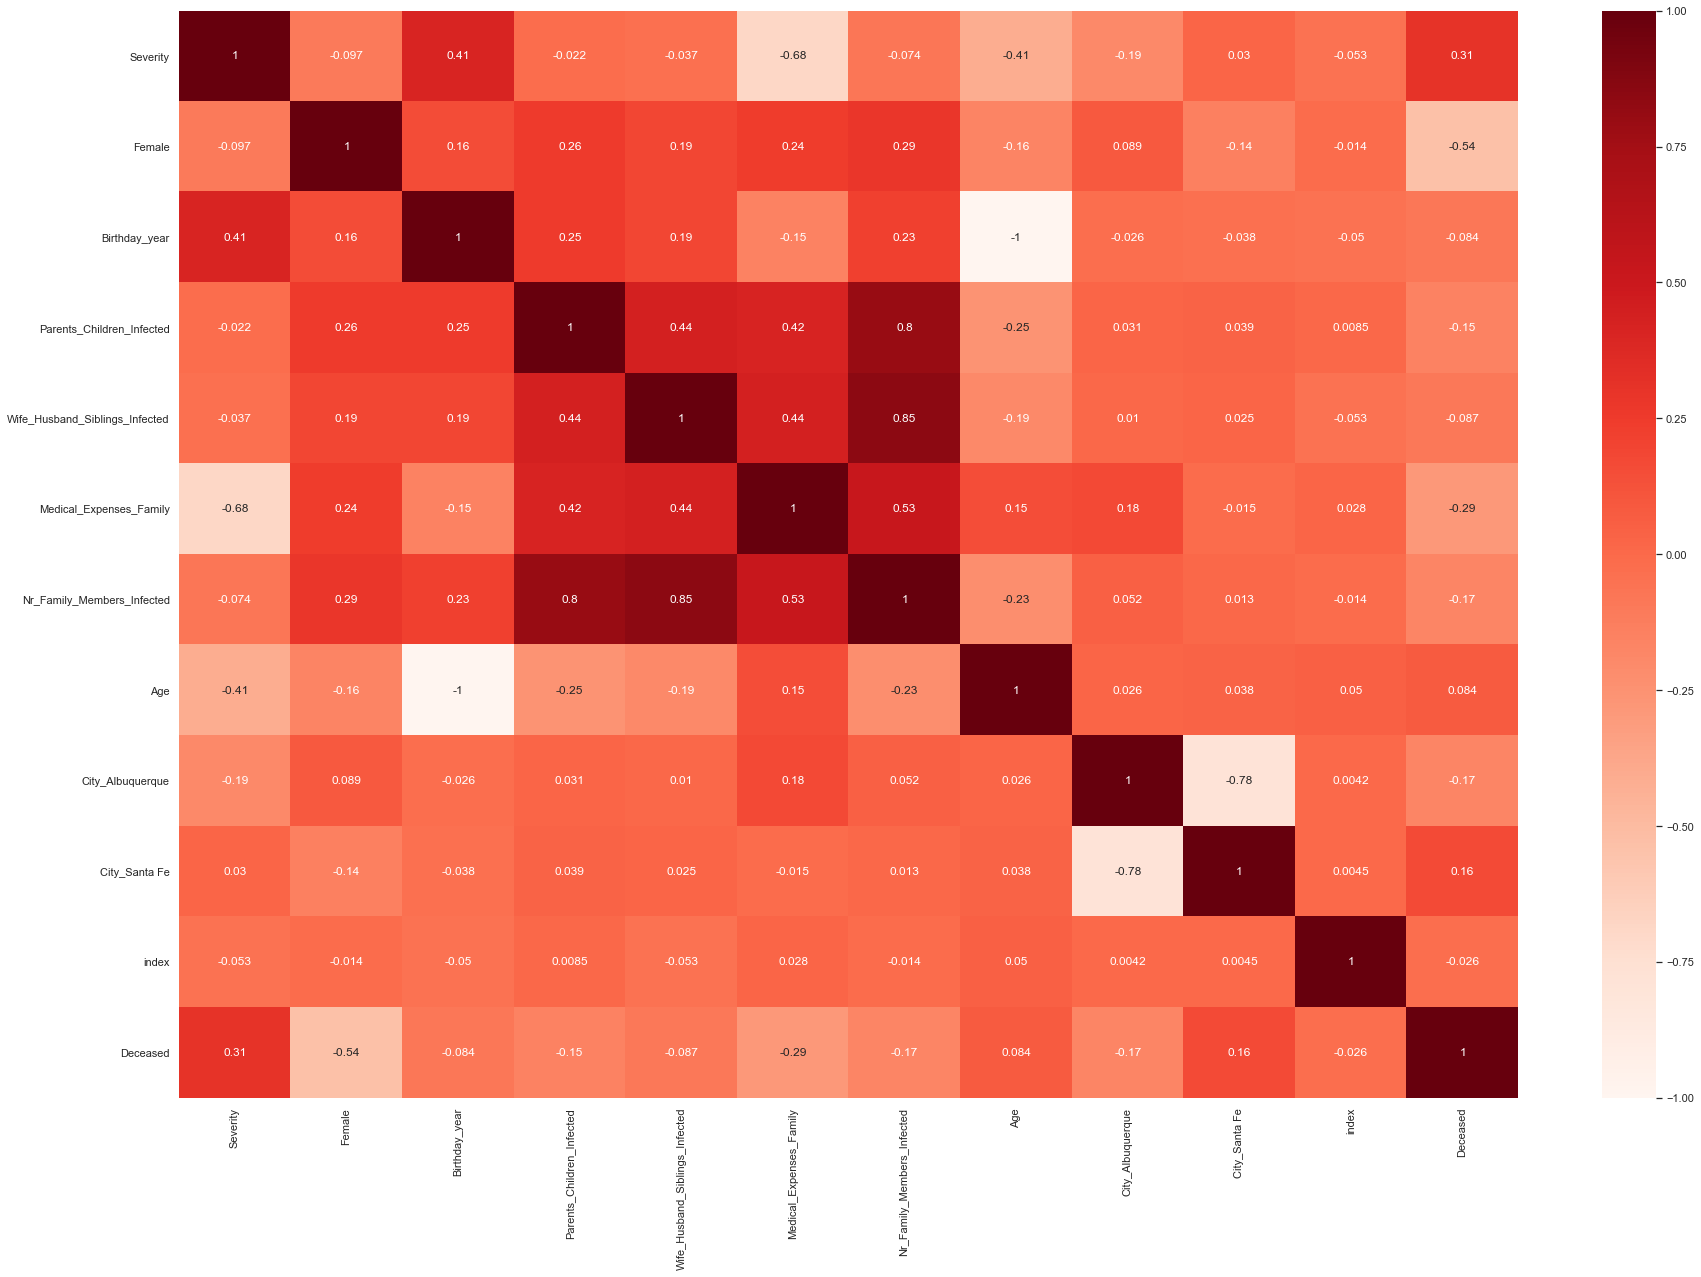

In [59]:
# Get Spearman matrix
cor_heatmap(cor_Spearman,30,20)

There are **no highly correlated variables with the target variable Deceased**. We will use these matrices to analyse which variables are highly correlated with each other and to support feature selection later on based on that.

**Ridge Classifier**

In [60]:
# Apply Ridge classifier
Ridge = RidgeClassifier().fit(X_train, y_train)
print("Best score using built-in LassoCV: %f" %Ridge.score(X_train,y_train))

Best score using built-in LassoCV: 0.791899


In [61]:
# Get coefficients
coefs = []
for i in Ridge.coef_:
    for j in i:
        coefs.append(j)

Female                           -0.473676
Birthday_year                    -0.097308
Parents_Children_Infected        -0.025121
City_Albuquerque                 -0.016339
Medical_Expenses_Family           0.027018
Nr_Family_Members_Infected        0.049418
City_Santa Fe                     0.053529
Wife_Husband_Siblings_Infected    0.089880
Age                               0.097308
Severity                          0.336539
dtype: float64


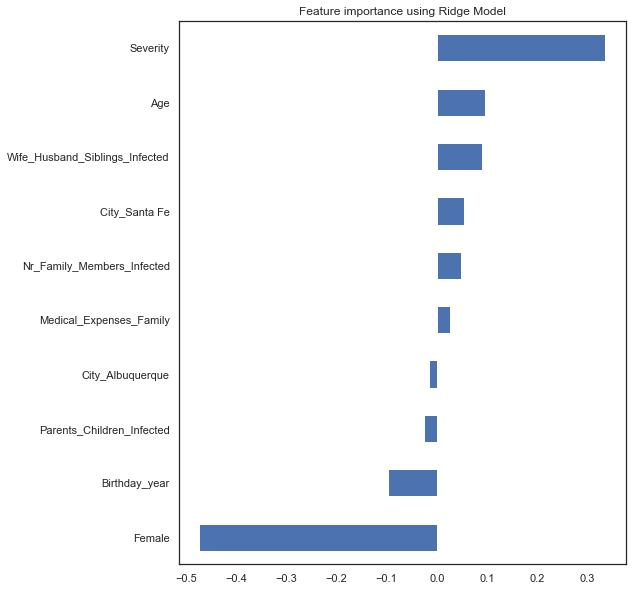

In [62]:
# Get results of variables' importances through Ridge
coef_ridge = pd.Series(coefs, index = X_train.columns).sort_values()
print(coef_ridge)

# Plot the importances of the different variables:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()
    
plot_importance(coef_ridge,'Ridge')

In [63]:
# select TOP 10 most important variables
TOPFeaturesRidge = coef_ridge.abs().sort_values()
TOPFeaturesRidge = TOPFeaturesRidge.tail(10)
TOPFeaturesRidge = list(TOPFeaturesRidge.index)

# Update Selection_Table
Selection_Table['Ridge Classifier']=np.where(Selection_Table['Variables'].isin(TOPFeaturesRidge),1,0)

**RFE**

In [64]:
# Implement RFE 
estimator = SVC(kernel="linear")
RFE_selector = RFE(estimator, n_features_to_select=10, step=1)
RFE_selector = RFE_selector.fit(X_train, y_train)

In [65]:
# Get best features
selected_features = pd.Series(RFE_selector.support_, index = X_train.columns)
TOPFeaturesRFE = selected_features[selected_features.values==True]
TOPFeaturesRFE = list(TOPFeaturesRFE.index)
TOPFeaturesRFE

['Severity',
 'Female',
 'Birthday_year',
 'Parents_Children_Infected',
 'Wife_Husband_Siblings_Infected',
 'Medical_Expenses_Family',
 'Nr_Family_Members_Infected',
 'Age',
 'City_Albuquerque',
 'City_Santa Fe']

In [66]:
# Update Selection_Table
Selection_Table['RFE']=np.where(Selection_Table['Variables'].isin(TOPFeaturesRFE),1,0)

In [67]:
# Fill column Count
Selection_Table['Count'] = Selection_Table['ANova'] + Selection_Table['Decision Tree'] + Selection_Table['Ridge Classifier'] + Selection_Table['RFE']

In [68]:
# Update selection table just for count higher than 1
Selection_Table = Selection_Table[Selection_Table.Count>1]
Selection_Table = Selection_Table.sort_values(by='Count', ascending=False)

In [69]:
# Create Correlation_Deceased on selection table
Selection_Table['Correlation_Deceased']=list(range(0,len(Selection_Table)))

In [70]:
# Get correlations with the target variable into selection table
for i in list(Selection_Table.Variables):
    Selection_Table.loc[Selection_Table.Variables==i,'Correlation_Deceased'] = cor_Pearson.loc[cor_Pearson.index==i,'Deceased'].values[0]

In [71]:
# Get selection table
Selection_Table

,Variables,ANova,Decision Tree,Ridge Classifier,RFE,Count,Correlation_Deceased
0,Severity,1,1,1,1,4,0.308949
1,Female,1,1,1,1,4,-0.538467
2,Birthday_year,1,1,1,1,4,-0.093285
3,Parents_Children_Infected,1,1,1,1,4,-0.086305
4,Wife_Husband_Siblings_Infected,1,1,1,1,4,0.039094
5,Medical_Expenses_Family,1,1,1,1,4,-0.237748
6,Nr_Family_Members_Infected,1,1,1,1,4,-0.016092
7,Age,1,1,1,1,4,0.093285
8,City_Albuquerque,1,1,1,1,4,-0.171449
9,City_Santa Fe,1,1,1,1,4,0.164797


To determine which of these variables should be used on the model, we took into consideration the correlations between variables. Some of these were not used on modelling as they were highly correlated (above 0.8) with each other. We also had in mind the correlations with the target variable and gave more importance to the higher correlated variables. We ended up choosing the following variables: **'Female','Severity',  'Medical_Expenses_Family', 'City_Albuquerque','City_Santa Fe','Age', 'Wife_Husband_Siblings_Infected'.**

In [72]:
# Reduce variables into the ones chosen on feature selection
X_train_selection = X_train[['Female','Severity',  'Medical_Expenses_Family', 'City_Albuquerque',
                    'City_Santa Fe','Age', 'Wife_Husband_Siblings_Infected']]
X_val_selection = X_val[['Female','Severity', 'Medical_Expenses_Family', 'City_Albuquerque',
                    'City_Santa Fe','Age', 'Wife_Husband_Siblings_Infected']]
X_test_selection = X_test[['Female','Severity',  'Medical_Expenses_Family', 'City_Albuquerque',
                    'City_Santa Fe','Age', 'Wife_Husband_Siblings_Infected']]

# <font color='#E8800A'>Modeling</font> <a class="anchor" id="fourth-bullet"></a>
  [Back to TOC](#menu)

Models used:
- KNN 
- Logistic Regression Classifier
- Naive Bayes 
- SVC - SVM 
- Decision Trees
- RNN 
- Random Forest

Ensemblers of models:
- Bagging
- Stacking

Extra libraries used: 
- Tensor flow
- keras 

<h2><font color='#1e91c7'>KNN</font> </h2>

**Try with default parameters**

In [73]:
# # Define and fit model
# KNN_model_default = KNeighborsClassifier()
# KNN_model_default.fit(X_train_selection,y_train)

# # Check scores
# print(KNN_model_default.score(X_train_selection,y_train))
# print(KNN_model_default.score(X_val_selection,y_val))
# # Low overfitting

**Try with best parameters**

In [74]:
# # Define and fit model
# KNN = KNeighborsClassifier(algorithm='brute',leaf_size=5,metric='mahalanobis',n_neighbors = 5,p=2,weights='uniform')
# KNN.fit(X_train_selection,y_train)

# # Check scores
# print(KNN.score(X_train_selection,y_train))
# print(KNN.score(X_val_selection,y_val))
# # Low overfitting

**Grid Search**

In [75]:
# # Define parameters of Grid Search 1
# parameter_space = {
#     'n_neighbors':[3,4,5,10,15,20,30,40],
#     'weights':['uniform','distance'],
#     'algorithm':['auto','ball_tree','kd_tree','brute'],
#     'leaf_size':[5,10,20,30,40,50],
#     'p':[1,2],
#     'metric':['minkowski','mahalanobis']
# }

In [76]:
# # Define and fit Grid Search 1
# clf_r1 = GridSearchCV(KNN_model_default, parameter_space, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=1,n_jobs=4)
# clf_r1.fit(X_train_selection,y_train)

In [77]:
# # Check Results

# # Get means, stds and parameters for all tried combinations
# means_test = pd.DataFrame(clf_r1.cv_results_['mean_test_score'])
# stds_test = pd.DataFrame(clf_r1.cv_results_['std_test_score'])
# params = clf_r1.cv_results_['params']

# # Build a data frame with these values
# results = pd.DataFrame(params)
# results = pd.concat([results,means_test], axis=1)
# results = pd.concat([results,stds_test],axis=1)
# results.columns=['algorithm','leaf_size','metric','n_neighbors','p','weights','mean_test','std_test'] 
# results = results.sort_values(by=['mean_test','std_test'], ascending=False)

# # Get models
# results.head(20) 

<h2><font color='#1e91c7'>Neural Networks</font> </h2>

**hidden_layer_sizes**: for a first approach decided to follow the recommended rules of thumb presented by the professor on a practical class:
- **The number of hidden neurons should be between the size of the input layer and the size of the output layer:** in our case the size of the input layer is of 7 and the output layer 2, so the number of neurons should be in the interval (2-7).
- **The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer:** in our case it should be (2/3) * 7 + 2 = 6.66  which in approximation is 7.
- **The number of hidden neurons should be less than twice the size of the input layer:** in our case it should be less than 2*7 = 14.

**Try with best parameters**

In [78]:
# # Define and fit model
# NN = MLPClassifier(early_stopping=True, activation='tanh',hidden_layer_sizes=(32,6),learning_rate_init=0.05,random_state=2,solver='adam')
# NN.fit(X_train_selection,y_train)

# # Check scores
# print(NN.score(X_train_selection,y_train))
# print(NN.score(X_val_selection,y_val))
# # Low overfitting

In [79]:
# # Dedine and fit model
# NN = MLPClassifier(early_stopping=True, activation='tanh',hidden_layer_sizes=(3,20,15),learning_rate='adaptive',learning_rate_init=0.05,random_state=1,solver='adam')
# NN.fit(X_train_selection,y_train)

# # Check scores
# print(NN.score(X_train_selection,y_train))
# print(NN.score(X_val_selection,y_val)) 

**Try with bagging**

In [80]:
# # Define and fit bagging
# bagging_nn_best = BaggingClassifier(base_estimator=MLPClassifier(
#                                         early_stopping=True, activation='tanh',hidden_layer_sizes=(3,20,15),
#                                         learning_rate='adaptive',learning_rate_init=0.05,random_state=1,solver='adam'),
#                         n_estimators=100, random_state=0)
# bagging_nn_best.fit(X_train_selection, y_train)

# # Check scores
# print(bagging_nn_best.score(X_train_selection, y_train))
# print(bagging_nn_best.score(X_val_selection, y_val))

**Grid Search**

In [81]:
# # Create model
# NN = MLPClassifier(early_stopping=True)

# # Define parameters of Grid Search 2
# parameter_space = {
#     'hidden_layer_sizes': [(2,),(4,),(7,),(2,2),(4,2),(2,4),(3,4),(4,3),(5,2),
#                            (2,5),(2,2,3),(3,2,2),(2,3,2),
#                            (7,7),(5,9),(9,5),(5,5,4),(4,5,5),(5,4,5)],
#     'activation': ['logistic','tanh','relu'],
#     'solver': ['lgfgs','sgd', 'adam'],
#     'learning_rate_init': [0.01,0.001,0.0001],
#     'random_state': [1,2,3,4],
#     'learning_rate': ['adaptive','constant','invscaling']
# }

In [82]:
# # Define and fit Grid Search 2
# clf_r2 = GridSearchCV(NN, parameter_space, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=1,n_jobs=4)
# clf_r2.fit(X_train_selection,y_train)

In [83]:
# # Check Results

# # Get means, stds and parameters for all tried combinations
# means_test = pd.DataFrame(clf_r2.cv_results_['mean_test_score'])
# stds_test = pd.DataFrame(clf_r2.cv_results_['std_test_score'])
# params = clf_r2.cv_results_['params']

# # Build a data frame with these values
# results = pd.DataFrame(params)
# results = pd.concat([results,means_test], axis=1)
# results = pd.concat([results,stds_test],axis=1)
# results.columns=['activation','hidden_layer_sizes','learning_rate','learning_rate_init','random_state','solver','mean_test','std_test'] 
# results = results.sort_values(by=['mean_test','std_test'], ascending=False)

# # Get models
# results.head(20) 

In [84]:
# # Define parameters of Grid Search 3
# parameter_space = {
#     'hidden_layer_sizes': [(4,10),(12,2),(2,12),(6,8),(8,6),(3,3,8),(8,3,3),(3,8,3),(4,4,4,2),(2,4,4,4),(4,2,4,4),(4,4,2,4)],
#     'activation': ['tanh'],
#     'solver': ['adam'],
#     'learning_rate_init': [0.01,0.015,0.05],
#     'random_state': [1,3],
#     'learning_rate': ['adaptive','constant','invscaling']
# }

In [85]:
# # Define and fit Grid Search
# clf_r3 = GridSearchCV(NN, parameter_space, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=1,n_jobs=4)
# clf_r3.fit(X_train_selection,y_train)

In [86]:
# # Check Results

# # Get means, stds and parameters for all tried combinations
# means_test = pd.DataFrame(clf_r3.cv_results_['mean_test_score'])
# stds_test = pd.DataFrame(clf_r3.cv_results_['std_test_score'])
# params = clf_r3.cv_results_['params']

# # Build a data frame with these values
# results = pd.DataFrame(params)
# results = pd.concat([results,means_test], axis=1)
# results = pd.concat([results,stds_test],axis=1)
# results.columns=['activation','hidden_layer_sizes','learning_rate','learning_rate_init','random_state','solver','mean_test','std_test'] 
# results = results.sort_values(by=['mean_test','std_test'], ascending=False)

# # Get models
# results.head(20) 

<h2><font color='#1e91c7'>Neural Networks with Keras</font> </h2>

<h3>Best Model</h3>

In [87]:
# def create_baseline():
#     # Create model
#     model = Sequential()
#     model.add(Dense(16, input_dim=len(X_final.columns), kernel_initializer='normal', activation='relu'))
#     model.add(Dense(16, input_dim=len(X_final.columns), kernel_initializer='normal', activation='relu'))
#     model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
#     # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model
 

# estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, X_final, y_final, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [88]:
# # load dataset
# # split into input (X) and output (Y) variables
# X = X_final
# Y = y_final
# # encode class values as integers
# encoded_Y = Y

# # ----------------------------------  baseline model  -------------------------------------------
# def create_baseline():
#     # create model
#     model = Sequential()
#     model.add(Dense(60, input_dim=len(X_train_selection.columns), activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model
# # evaluate model with standardized dataset
# estimator = KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
# print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

# # Binary Classification with Dataset:  Larger

# # load dataset
# # split into input (X) and output (Y) variables
# X = X_final
# Y = y_final
# # encode class values as integers
# encoded_Y = Y
# # larger model
# def create_larger():
#     # create model
#     model = Sequential()
#     model.add(Dense(60, input_dim=len(X_train_selection.columns), activation='relu'))
#     model.add(Dense(30, activation='relu'))
#     model.add(Dense(1, activation='sigmoid'))
#     # Compile model
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#     return model
# estimators = []
# estimators.append(('mlp', KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)))
# pipeline = Pipeline(estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
# print("Larger: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [89]:
# # Check scores
# pipeline.fit(X_final, y_final)
# print(pipeline.score(X_train_selection,y_train))
# print(pipeline.score(X_val_selection, y_val))

<h2><font color='#1e91c7'>DT Models</font> </h2>

In [90]:
# def calculate_AUC(interval, x_train, x_test, y_train, y_test, parameter, max_depth = None):
#     train_results = []
#     test_results = []
#     for value in interval:
#         if (parameter == 'depth'):          
#             dt = DecisionTreeClassifier(max_depth = value)
#             dt.fit(x_train, y_train)
#         elif (parameter == 'features'):  
#             dt = DecisionTreeClassifier(max_features = value, max_depth = max_depth)
#             dt.fit(x_train, y_train)
#         elif (parameter == 'min_samples_split'):  
#             dt = DecisionTreeClassifier(min_samples_split = value, max_depth = max_depth)
#             dt.fit(x_train, y_train)
#         elif (parameter == 'max_leaf_nodes'):  
#             dt = DecisionTreeClassifier(max_leaf_nodes = value, max_depth = max_depth)
#             dt.fit(x_train, y_train)
#         elif (parameter == 'min_samples_leaf'):  
#             dt = DecisionTreeClassifier(min_samples_leaf = value, max_depth = max_depth)
#             dt.fit(x_train, y_train)
#         train_pred = dt.predict(x_train)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         # Add auc score to previous train results
#         train_results.append(roc_auc)
#         y_pred = dt.predict(x_test)
#         false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
#         roc_auc = auc(false_positive_rate, true_positive_rate)
#         # Add auc score to previous test results
#         test_results.append(roc_auc)
#     value_train = train_results.index(max(train_results))
#     value_test = test_results.index(max(test_results))
#     print('The best train value is ',interval[value_train])
#     print('The best test value is ',interval[value_test])

#     import matplotlib.pyplot as plt
#     from matplotlib.legend_handler import HandlerLine2D
#     line1, = plt.plot(interval, train_results, 'b', label="Train AUC")
#     line2, = plt.plot(interval, test_results, 'r', label="Test AUC")
#     plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
#     plt.ylabel("AUC score")
#     plt.xlabel(str(parameter))
#     plt.show()

In [91]:
# max_depths = list(range(1,30))
# calculate_AUC(max_depths, X_train_selection, X_val_selection, y_train, y_val, 'depth')

In [92]:
# max_features = list(range(1,len(X_train_selection.columns)+1))
# calculate_AUC(max_features, X_train_selection, X_val_selection, y_train, y_val,'features',7)

In [93]:
# min_samples = list(range(2,200,10))
# calculate_AUC(min_samples, X_train_selection, X_val_selection, y_train, y_val,'min_samples_split',7)

In [94]:
# leaf_nodes = list(range(2,300,5))
# calculate_AUC(leaf_nodes, X_train_selection, X_val_selection, y_train, y_val, 'max_leaf_nodes',7)

In [95]:
# min_samples_leaf = list(range(2,200,5))
# calculate_AUC(min_samples_leaf, X_train_selection, X_val_selection, y_train, y_val, 'min_samples_leaf',7)

**Try with default parameters**

In [96]:
# # Define and fit model
# dt_model_default = DecisionTreeClassifier()
# dt_model_default.fit(X_train_selection, y_train)
# dt_model_default.score(X_val_selection, y_val)

**Try with best parameters**

In [97]:
# # Define and fit model
# dt_model_best = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features=7, max_leaf_nodes=None, min_samples_leaf=1,min_samples_split=2, splitter='random')
# dt_model_best.fit(X_train_selection, y_train)
# dt_model_best.score(X_val_selection, y_val)

**Try with bagging**

In [98]:
# # Define and fit model
# bagging_dt = BaggingClassifier(base_estimator = DecisionTreeClassifier(), random_state = 5)
# bagging_dt.fit(X = X_train_selection, y = y_train)

# print(bagging_dt.score(X_train_selection, y_train))
# print(bagging_dt.score(X_val_selection, y_val))

In [99]:
# # Define and fit model
# bagging_dt_best = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=7, max_features=4, min_samples_split=2),
#                         n_estimators=100, random_state=0)
# bagging_dt_best.fit(X_train_selection, y_train)
# print(bagging_dt_best.score(X_train_selection, y_train))
# print(bagging_dt_best.score(X_val_selection, y_val))

**Grid Search**

In [100]:
# # Define parameters for grid search
# import random
# dt_model = DecisionTreeClassifier()
# params_dt={
    
#     "splitter": ['random','best'], 
#     "max_depth": [5,7,9,10,15,26,27], 
#     "min_samples_split": [2,10,75,125], 
#     "min_samples_leaf": [1,50,170,400], 
#     "criterion": ['gini', 'entropy'], 
#     "max_leaf_nodes":[None,100,177,217],
#     "max_features": [random.randint(1, 9),'auto','sqrt','log2'],
#     "class_weight": [None, 'balanced']
#     }

In [101]:
# # Define and fit grid search
# Model_DT = GridSearchCV(dt_model, params_dt)
# Model_DT.fit(X_train_selection,y_train)

In [102]:
# # Check scores
# print(Model_DT.score(X_train_selection, y_train))
# print(Model_DT.score(X_val_selection, y_val))

<h2><font color='#1e91c7'>SVM</font> </h2>

**Try with default parameters**

In [103]:
# # Define and fit model
# svm_model_default = svm.SVC()
# svm_model_default.fit(X_train_selection, y_train)

# # Check scores
# print(svm_model_default.score(X_train_selection, y_train))
# print(svm_model_default.score(X_val_selection, y_val))

**Try with best parameters**

In [104]:
# # Define and fit model
# svm_model_best = svm.SVC(C=3, break_ties=False, decision_function_shape='ovo', gamma='scale', kernel='rbf', probability=True, shrinking=True)
# svm_model_best.fit(X_train_selection, y_train)
# print(svm_model_default.score(X_train_selection, y_train))
# print(svm_model_best.score(X_val_selection, y_val))

**Grid Search**

In [105]:
# # Define parameters for Grid Search
# svm_model = svm.SVC()

# params_svm={
#          "C": [0.1, 1, 2 ,3], 
#          "kernel": ['linear', 'poly', 'rbf', 'sigmoid'],  #[sigmoid] presented worst results
#          "degree": [3,5,10], 
#          "gamma": ['scale','auto'], 
#          #"coef0": [0,1,2], 
#          "shrinking": [True,False],
#          #"probability": [True,False],
#          #"tol": [1e-3],
#          #"cache_size": [200,400],
#          "class_weight": ['balanced', None],
#          #"verbose": [True,False],
#          "max_iter": [-1,200,300],
#          "decision_function_shape": ['ovo', 'ovr'],
#          "break_ties": [False]
#         }

In [106]:
# # Define and fit grid search
# ModelSVM =  GridSearchCV(svm_model, params_svm, cv = StratifiedKFold(n_splits = 3, shuffle = True),verbose = 1,n_jobs = 4)
# ModelSVM.fit(X_train_selection, y_train)

# Best parameter set
#print('------------------------------------------------------------------------------------------------------------------------')
#print('Best parameters found:\n', grid_search_selection.best_params_)
#print('------------------------------------------------------------------------------------------------------------------------')

# All results
#means = grid_search_selection.cv_results_['mean_test_score']
#stds = grid_search_selection.cv_results_['std_test_score']
#for mean, std, params in zip(means, stds, grid_search_selection.cv_results_['params']):
   # print("%0.3f (+/-%0.03f) for %r" % (mean, std , params))

In [107]:
# # Define and fit model
# params_svm={'C': 3, 
#             'break_ties': False, 
#              "class_weight": {1:1.3,1:0.8},
#             'decision_function_shape': 'ovo', 
#             'degree': 3, 
#             'gamma': 'auto', 
#             'kernel': 'rbf', 
#             'probability': True, 
#             'shrinking': True, 
#             'verbose': True}

# tes_model = svm.SVC(**params_svm)
# tes_model.fit(X_train_selection, y_train)

In [108]:
# # Check scores
# tes_model.score(X_train_selection, y_train)
# tes_model.score(X_val_selection, y_val)

<h2><font color='#1e91c7'>Random Forest Models</font> </h2>

**Try with default parameters**

In [109]:
# # Define and fit model
# rf_model_default = RandomForestClassifier()
# rf_model_default.fit(X_train_selection, y_train)

# # Check scores
# print(rf_model_default.score(X_train_selection, y_train))
# print(rf_model_default.score(X_val_selection, y_val))

**Try with best parameters**

In [110]:
# # Define and fit model
# RFM_model_best = RandomForestClassifier(random_state = 2,
#                                   n_estimators = 200,
#                                   max_depth = 5,
#                                   min_samples_split = 5,  min_samples_leaf = 2)
# RFM_model_best.fit(X_train_selection, y_train)

# # Check scores
# print(RFM_model_best.score(X_train_selection, y_train))
# print(RFM_model_best.score(X_val_selection, y_val))

In [111]:
# # Dedine parameters for grid search
# RFM = RandomForestClassifier()
# # Define parameters of Grid Search
# parameter_space = {
#     'n_estimators':[10,20] ,
#     'criterion':['gini','entropy'],
#     'max_depth': [5,7,9,10], 
#     'min_samples_split': [2,10,75],
#     'min_samples_leaf': [1,50,170],
#     'max_features': [7,8,9,'auto','sqrt','log2'],
#     'max_leaf_nodes':[None,100,177,217],
#     'random_state':[1,2,3,4],
#     'class_weight': ['balanced','balanced_subsample']
# }

In [112]:
# # Define and fit model
# clf_r4 = GridSearchCV(RFM, parameter_space, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=1,n_jobs=4)
# clf_r4.fit(X_train_selection,y_train)

 <h2><font color='#1e91c7'>Logistic Regression</font> </h2>

**Try with default parameters**

In [113]:
# # Define and fit model
# LG_model_default = LogisticRegression()
# LG_model_default.fit(X_train,y_train)

# # Check scores
# print(LG_model_default.score(X_train,y_train))
# print(LG_model_default.score(X_val,y_val))
# # Low overfitting

**Try with best parameters**

In [114]:
# # Best parameters
# LG_model_best = LogisticRegression()
# LG_model_best.fit(X_train_selection,y_train)

# # Check scores
# print(LG_model_best.score(X_train_selection,y_train))
# print(LG_model_best.score(X_val_selection,y_val))

**GridSearchCV**

In [115]:
# # Define parameters for grid search
# LG = LogisticRegression()


# parameter_space_lr = {
#     'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 5, 15),
#     'class_weight':['balanced'],
#     'random_state': [1,3,5],
#     'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#     'multi_class' : ['auto', 'ovr', 'multinomial'],
    
# }

In [116]:
# # Define and fit grid search
# ModelLR = GridSearchCV(LG, parameter_space_lr)
# ModelLR.fit(X_train_selection,y_train)

 <h2><font color='#1e91c7'>Naive Bayes</font> </h2>

**Try with default parameters**

In [117]:
# from sklearn.naive_bayes import GaussianNB
# # Define and fit model
# NB_model_default = GaussianNB()
# NB_model_default.fit(X_train_selection,y_train)

# # Check scores
# print(NB_model_default.score(X_train_selection,y_train))
# print(NB_model_default.score(X_val_selection,y_val))

**Try with best parameters**

In [118]:
# # Define and fit model
# NB_model_default = GaussianNB()
# NB_model_default.fit(X_train_selection,y_train)

# # Check scores
# print(NB_model_default.score(X_train_selection,y_train))
# print(NB_model_default.score(X_val_selection,y_val))

 <h2><font color='#1e91c7'>XGBClassifier</font> </h2>

**Try with default parameters**

In [119]:
# # pip install xgboost
# # Default Params
# xgb_model_default = XGBClassifier()
# xgb_model_default.fit(X_train_selection,y_train)

# # Check scores
# print(xgb_model_default.score(X_train_selection,y_train))
# print(xgb_model_default.score(X_val_selection,y_val))

**Try with best parameters**

In [120]:
# # Define model
# XB = XGBClassifier()

# # Define parameters of Grid Search
# parameter_space = {
#     'booster':['gbtree', 'gblinear', 'dart'],
#     'eta':[0.01,0.1,0.2],
#     'gamma':[0,1,2],
#     'max_depth':[3,6,7,8,10],
#     'subsample':[0.8,1],
#     'lambda':[1,2],
#     'alpha':[1,2],
#     'grow_policy':['depthwise','lossguide'],
#     'max_leaves':[0,10,50],
#     'predictor':['auto','cpu_predictor','gpu_predictor'],
#     'objective':['binary:logistic']   
# }

In [121]:
# # Define and fit grid search 
# clf_r5 = GridSearchCV(XB, parameter_space, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=1,n_jobs=-1)
# clf_r5.fit(X_train_selection,y_train)
# clf_r5.best_params_

In [122]:
# # Define and fit model
# XB_best = XGBClassifier(booster ='gbtree',eta = 0.1, gamma = 1, grow_policy ='depthwise',
#                         max_depth = 3, max_leaves = 0, objective = 'binary:logistic',
#                         predictor = 'auto',subsample =1)
# XB_best.fit(X_train_selection,y_train)

# # Check scores
# print(XB_best.score(X_train_selection,y_train))
# print(XB_best.score(X_val_selection,y_val))

 <h2><font color='#1e91c7'>Ensemblers</font> </h2>

**Bagging**

In [123]:
# # Define and fit model
# bagging_best_models = BaggingClassifier(base_estimator = DecisionTreeClassifier(), random_state = 5)
# bagging_best_models.fit(X = X_train_selection, y = y_train)

# # Check scores
# print(bagging_best_models.score(X_train_selection, y_train))
# print(bagging_best_models.score(X_val_selection, y_val))

**Stacking**

In [124]:
# from matplotlib import pyplot
# def get_stacking():
#     # define the base models
#     level0 = list()
#     level0.append(('xgb', XGBClassifier(alpha =2 ,booster ='gbtree',eta = 0.2, gamma = 0, grow_policy ='depthwise',
#                         max_depth = 6,max_leaves = 0, objective = 'binary:logistic',
#                         predictor = 'auto',subsample =1)))
#     level0.append(('svc', svm.SVC(C=3,
#             break_ties= False,
#              class_weight= None,
#             decision_function_shape= 'ovo',
#             degree= 2,
#             gamma= 'auto',
#             kernel= 'rbf',
#             probability= True,
#             shrinking= True,
#             verbose= True)))
#     level0.append(('knn', KNeighborsClassifier(
#         algorithm='brute',leaf_size=5,metric='mahalanobis',n_neighbors = 5,p=2,weights='uniform')))
#     # define meta learner model
#     level1 = LogisticRegression()
#     # define the stacking ensemble
#     model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
#     return model
# def get_models():
#     models = dict()
#     models['svc'] = SVC(C=3,
#             break_ties= False,
#              class_weight= None,
#             decision_function_shape= 'ovo',
#             degree= 2,
#             gamma= 'auto',
#             kernel= 'rbf',
#             probability= True,
#             shrinking= True,
#             verbose= True)
#     models['xgb'] = XGBClassifier(alpha =2 ,booster ='gbtree',eta = 0.2, gamma = 0, grow_policy ='depthwise',
#                         max_depth = 6,max_leaves = 0, objective = 'binary:logistic',
#                         predictor = 'auto',subsample =1)
#     models['knn'] = KNeighborsClassifier(
#                         algorithm='brute',leaf_size=5,metric='mahalanobis',n_neighbors = 5,p=2,weights='uniform')
#     models['stacking'] = get_stacking()
#     return models

# # compare standalone models for binary classification
# def evaluate_model(model):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     scores = cross_val_score(model, X_train_selection, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
#     return scores

 

# # get the models to evaluate
# models = get_models()
# # evaluate the models and store results
# results, names = list(), list()
# for name, model in models.items():
#     scores = evaluate_model(model)
#     results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# # plot model performance for comparison
# pyplot.boxplot(results, labels=names, showmeans=True)
# pyplot.show()

In [125]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import StackingClassifier
# my_labels = {0:'low', 1:'medium', 2:'high'}
# my_labels
# level0 = list()

 

# level0.append(('xgb', XGBClassifier(alpha =2 ,booster ='gbtree',eta = 0.2, gamma = 0, grow_policy ='depthwise',
#                         max_depth = 6,max_leaves = 0, objective = 'binary:logistic',
#                         predictor = 'auto',subsample =1)))
# level0.append(('svc', svm.SVC(C=3,
#             break_ties= False,
#              class_weight= None,
#             decision_function_shape= 'ovo',
#             degree= 2,
#             gamma= 'auto',
#             kernel= 'rbf',
#             probability= True,
#             shrinking= True,
#             verbose= True)))
# level0.append(('knn', KNeighborsClassifier(
#         algorithm='brute',leaf_size=5,metric='mahalanobis',n_neighbors = 5,p=2,weights='uniform')))
# # define meta learner model
# level1 = LogisticRegression()
# # define the stacking ensemble
# model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# # fit the model on all available data
# model.fit(X_final, y_final)
# # make a prediction for one example

<h3>Best Model</h3>
<br>
Our model has 3 hidden layers plus the input columns that is the first layer with 7 nodes (correspond to the dataframe columns). The output layer contains a single neuron in order to make predictions. It uses the sigmoid activation function in order to produce a probability output in the range of 0 to 1 that can easily and automatically be converted to crisp class values (0 and 1).
Finally, we are using the logarithmic loss function (binary_crossentropy) during training, after some search on the internet we think this is preferred loss function for binary classification problems. The model also uses the efficient Adam optimization algorithm for gradient descent and accuracy metrics are collected to test the performance of the model.
Neural networks of Keras use randomness by design to ensure they effectively learn the function that is more approximated for the problem. Although, we have searched how to do set a random state do get reproducible results with Keras, unfortunately, it was not possible due to the complications and limitations of tensorFlow library.
In this way, our Keras Neural network algorithm is stochastic.

In [126]:
# Get final data set by concatenating train and validation sets in order to have more data to train the model
X_final = pd.concat([X_train_selection, X_val_selection], axis=0)
y_final = pd.concat([y_train, y_val], axis=0)

In [127]:
# Best Model configuration
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(16, input_dim=len(X_final.columns), kernel_initializer='normal', activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
estimator = KerasClassifier(build_fn=create_model, epochs=100, batch_size=5, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_final, y_final, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 82.24% (3.88%)


<h1>Predictions

In [128]:
# Fit best model
estimator.fit(X_final,y_final)

# Get predictions
predictions = estimator.predict(X_test_selection)
predictions = [list(dftest.ID), predictions]
predictions = pd.DataFrame(predictions)
predictions = predictions.transpose().rename(columns={0 : "Patient_ID", 1: "Deceased"})
predictions.Deceased = predictions.apply(lambda row: row.Deceased[0], axis=1)

# Get number of individuals by Deceased class
print('1', len(predictions[predictions['Deceased']==1]), '|', '0', len(predictions[predictions['Deceased']==0]))

# Export csv for submission
predictions.to_csv(r'group20_final_2.csv', sep = ',', index = False, header=True)

1 269 | 0 131


# <font color='#E8800A'>Conclusion</font> <a class="anchor" id="fifth-bullet"></a>
  [Back to index](#menu)

Throughout this project, we were challenged to put into practice what we learned through the Machine Learning course. The aim of this project was to create a model and achieve the best accuracy possible in a problem of binary classification.
In order to obtain our final model, we have tried several approaches and different combinations of parameters for various models. Our best model consisted of a Neural Network using the keras library, and it has achieved an accuracy score of **0.85833** on public leaderboard of kaggle.
This project helped us to have a bigger perspective on the applicability of Machine Learning in real-life problems, and how difficult it is to deal with day-to-day data.